In [16]:
!pip install datasets torcheval fastprogress fastcore

In [1]:
from datasets import load_dataset
import torchvision.transforms.functional as TF
import torch
from torch import nn,tensor
import torch.nn.functional as F
from operator import itemgetter
from torch.utils.data import default_collate, DataLoader

/Applications/anaconda3/envs/py_main_v2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
g = 784
m = nn.Sequential(nn.Linear(g, 50), nn.ReLU(), nn.Linear(50, 10))
t = torch.randn(2, g)
m(t)

tensor([[-0.0214,  0.1406, -0.1751,  0.0648, -0.1705,  0.0588, -0.1111, -0.0332,
          0.3879, -0.3144],
        [ 0.2268,  0.1256, -0.0925,  0.0632, -0.2830,  0.0299,  0.2020,  0.1026,
          0.1944, -0.3026]], grad_fn=<AddmmBackward0>)

In [4]:
x,y = 'image','label'
name = 'fashion_mnist'
dsr = load_dataset(name)

Found cached dataset fashion_mnist (/Users/arun/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)
100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


In [5]:
def inplace(f):
  def _f(b):
    f(b)
    return b
  return _f

@inplace
def transform(b):
  b[x] = [torch.flatten(TF.to_tensor(i)) for i in b[x]]

dst = dsr.with_transform(transform)

In [6]:
dst

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [7]:
def get_dls(train, valid, batch_size, **kwargs):
  return (
      DataLoader(train, batch_size=batch_size, shuffle=True, **kwargs),
      DataLoader(valid, batch_size=batch_size*2, shuffle=False, **kwargs),
  )

def collate_dict(trds):
  g = itemgetter(*trds.features)
  def _f(b):
    return g(default_collate(b))
  return _f

class DataLoaders:
  def __init__(self, *ds):
    self.train,self.valid = ds[:2]

  @classmethod
  def from_dd(cls, ds, batch_size, **kwargs):
    f = collate_dict(ds['train'])
    return cls(*get_dls(*ds.values(), batch_size, collate_fn=f, **kwargs))

In [8]:
t = [{'a': [1], 'b': [2]}, {'a': [1], 'b': [2]}]
k = default_collate(t)
g = itemgetter('a', 'b')
g(k)

([tensor([1, 1])], [tensor([2, 2])])

In [9]:
bs = 1024
dls = DataLoaders.from_dd(dst, batch_size=bs)
xb,yb = next(iter(dls.train))
xb.shape,yb.shape

(torch.Size([1024, 784]), torch.Size([1024]))

In [10]:
## Basic Learner

In [12]:
import fastcore.all as fc
from torch import optim

/Applications/anaconda3/envs/py_main_v2/lib/python3.9/site-packages/fastprogress/fastprogress.py:107: UserWarning: Couldn't import ipywidgets properly, progress bar will use console behavior
  warn("Couldn't import ipywidgets properly, progress bar will use console behavior")


In [13]:
class Learner:
  def __init__(self, model, dls, lr, loss_func=F.cross_entropy, opt_func=optim.SGD):
    fc.store_attr()

  @property
  def training(self):
    return self.model.training

  def calc_stats(self):
    n = len(self.xb)
    self.accs.append((self.preds.argmax(dim=1)==self.yb).float().sum())
    self.losses.append(self.loss*n)
    self.ns.append(n)

  def one_batch(self):
    self.xb,self.yb = self.batch
    self.preds = self.model(self.xb)
    self.loss = self.loss_func(self.preds, self.yb)
    if self.training:
      self.loss.backward()
      self.opt.step()
      self.opt.zero_grad()
    self.calc_stats()

  def one_epoch(self, train):
    self.model.training = train
    self.dl = self.dls.train if train else self.dls.valid
    for self.batch in self.dl:
      self.one_batch()
    n = sum(self.ns)
    avgacc = sum(self.accs).item()/n
    avgloss = sum(self.losses).item()/n
    print(f'train:{train}, acc:{avgacc:.2}, loss:{avgloss:.2}')

  def fit(self, n_epochs):
    self.n_epochs = n_epochs
    self.ns,self.accs,self.losses = [],[],[]
    self.opt = self.opt_func(self.model.parameters(), lr=self.lr)
    for self.epoch in range(n_epochs):
      self.one_epoch(True)
      with torch.no_grad():
        self.one_epoch(False)

In [14]:
m,nh,nout = 784,50,10
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,nout))
learner = Learner(model, dls, lr=0.2)

In [15]:
learner.fit(1)

train:True, acc:0.61, loss:1.2
train:False, acc:0.62, loss:1.1


In [16]:
## Learner with Callbacks

In [17]:
class CancelFitException(Exception):
  pass

class CancelEpochException(Exception):
  pass

class CancelBatchException(Exception):
  pass

In [18]:
class Callback:
  order = 0

def run_cbs(cbs, method_nm, learn=None):
  for cb in sorted(cbs, key=lambda x: x.order):
    method = getattr(cb, method_nm, None)
    if method is not None:
      method(learn)

class CompletionCB(Callback):
  def before_epoch(self, learn):
    self.n = 0

  def after_batch(self, learn):
    self.n += 1

  def after_epoch(self, learn):
    print(f'total batch process: {self.n}')

cbs = [CompletionCB()]
run_cbs(cbs, 'before_epoch')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_epoch')

total batch process: 3


In [19]:
### Metrics

In [20]:
class Metric:
  def __init__(self, nm):
    self.nm = nm
    self.reset()

  def reset(self):
    self.ns,self.vals = [],[]

  def add(self, out, targ=None, n=1):
    val = self.calc(out, targ)
    self.ns.append(n)
    self.vals.append(val)

  def compute(self):
    ns = sum(self.ns) or 1
    avgval = sum(tensor(self.vals)*tensor(self.ns)).item()/ns
    print(f'{self.nm}: {avgval:.2}')

  def calc(self, out, targ=None):
    return out

In [21]:
loss_metric = Metric('loss')
loss_metric.add(0.6, n=32)
loss_metric.add(0.9, n=2)
loss_metric.compute()

loss: 0.62


In [22]:
class Accuracy(Metric):
  def calc(self, out, targ):
    return (out==targ).float().mean()

In [23]:
acc_metric = Accuracy('accuracy')
acc_metric.add(tensor([0, 1, 2, 0, 1, 2]), tensor([0, 1, 1, 2, 1, 0]))
acc_metric.add(tensor([1, 1, 2, 0, 1]), tensor([0, 1, 1, 2, 1]))
acc_metric.compute()

accuracy: 0.45


In [24]:
from torcheval.metrics import Mean, MulticlassAccuracy

In [25]:
acc_metric_v2 = MulticlassAccuracy()
acc_metric_v2.update(tensor([0, 1, 2, 0, 1, 2]), tensor([0, 1, 1, 2, 1, 0]))
acc_metric_v2.update(tensor([1, 1, 2, 0, 1]), tensor([0, 1, 1, 2, 1]))
acc_metric_v2.compute()

tensor(0.4545)

In [26]:
loss_metric_v2 = Mean()
loss_metric_v2.update(tensor(0.6), weight=32)
loss_metric_v2.update(tensor(0.9), weight=2)
loss_metric_v2.compute()

tensor(0.6176, dtype=torch.float64)

In [27]:
type(Mean())

torcheval.metrics.aggregation.mean.Mean

In [28]:
from collections.abc import Mapping
from copy import copy

In [29]:
# move all data to cpu before performing any metric calculation.
# this is to avoid any gradient accumulation + freeup gpu.
def to_cpu(x):
  if isinstance(x, Mapping):
    return {k:to_cpu(i) for k,i in x.items()}
  if isinstance(x, list):
    return [to_cpu(i) for i in x]
  if isinstance(x, tuple):
    return tuple(to_cpu(list(x)))
  res = x.detach().cpu()
  return res.float() if res.dtype==torch.float16 else res

In [66]:
class MetricsCB(Callback):
  def __init__(self, *ms, **metrics):
    for i in ms:
      metrics[type(i).__name__] = i
    self.metrics = metrics
    self.all_metrics = copy(self.metrics)
    self.all_metrics['loss'] = self.loss = Mean()

  def before_fit(self, learn):
    learn.metrics = self

  def before_epoch(self, learn):
    [i.reset() for i  in self.all_metrics.values()]

  def after_batch(self, learn):
    x,y,*_ = to_cpu(learn.batch)
    for i in list(self.metrics.values()):
      i.update(to_cpu(learn.preds), y)
    self.loss.update(to_cpu(learn.loss), weight=len(x))

  def after_epoch(self, learn):
    log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
    log['epoch'] = f'{learn.epoch}'
    log['train'] = 'train' if learn.model.training else 'eval'
    self._log(log)

  def _log(self, d):
    print(d)

In [31]:
t = {'a': [1]}
b = copy(t)
print(b)
print('-----')
b['a'].append(2)
print(b['a'])
print(t['a'])

{'a': [1]}
-----
[1, 2]
[1, 2]


In [32]:
def get_model():
  return nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, nout))
get_model()

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [33]:
## Flxible Learner

In [34]:
class with_cbs:
  def __init__(self, nm):
    self.nm = nm

  def __call__(self, f):
    def _f(o, *args, **kwargs):
      try:
        o.callback(f'before_{self.nm}')
        f(o, *args, **kwargs)
        o.callback(f'after_{self.nm}')
      except globals()[f'Cancel{self.nm.title()}Exception']:
        pass
      finally:
        o.callback(f'cleanup_{self.nm}')
    return _f

In [35]:
import torch.nn.functional as F
from torch import optim

In [36]:
class Learner:
  def __init__(self, model, dls, lr=0.2, loss_func=F.cross_entropy, opt_func=optim.SGD, cbs=None):
     cbs = fc.L(cbs)
     fc.store_attr()

  def callback(self, method_nm):
    run_cbs(self.cbs, method_nm, self)

  @property
  def training(self):
    return self.model.training

  @with_cbs('batch')
  def _one_batch(self):
    self.xb,self.yb = self.batch
    self.preds = self.model(self.xb)
    self.loss = self.loss_func(self.preds, self.yb)
    if self.training:
      self.loss.backward()
      self.opt.step()
      self.opt.zero_grad()

  @with_cbs('epoch')
  def _one_epoch(self):
    for self.batch in self.dl:
      self._one_batch()

  def one_epoch(self, training):
    self.model.train(training)
    self.dl = self.dls.train if training else self.dls.valid
    self._one_epoch()

  @with_cbs('fit')
  def _fit(self, train, valid):
    for self.epoch in self.epochs:
      if train:
        self.one_epoch(True)
      if valid:
        self.one_epoch(False)

  def fit(self, n_epochs, lr=None, cbs=None, train=True, valid=True):
    cbs = fc.L(cbs)
    for cb in cbs:
      self.cbs.add(cb)
    lr = self.lr if lr is None else lr
    self.opt = self.opt_func(self.model.parameters(), lr=lr)
    self.n_epochs = n_epochs
    self.epochs = range(n_epochs)
    try:
      self._fit(train, valid)
    finally:
      for cb in cbs:
        self.cbs.remove(cb)

In [44]:
model = get_model()
cbs = [MetricsCB(accuracy=MulticlassAccuracy())]
learner = Learner(model, dls=dls, cbs=cbs)
learner.fit(1)

{'accuracy': '0.607', 'loss': '1.176', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.701', 'loss': '0.831', 'epoch': 0, 'train': 'eval'}


In [45]:
## Progress Bar

In [46]:
from fastprogress import progress_bar, master_bar
import time

In [47]:
t = master_bar(range(2))
for i in t:
  for j in progress_bar(range(2), parent=t, leave=False):
    print(j)
    time.sleep(1)

0poch 1/2 : |----------------------------------------| 0.00% [0/2 00:00<?]
1poch 1/2 : |████████████████████--------------------| 50.00% [1/2 00:01<00:01]
0poch 2/2 : |----------------------------------------| 0.00% [0/2 00:00<?]      
1poch 2/2 : |████████████████████--------------------| 50.00% [1/2 00:01<00:01]


In [49]:
mb = master_bar(range(1))
mb.names = ['cos', 'sin']
for i in mb:
  for k in progress_bar(range(1000), parent=mb):
    if k%300 ==0 or k+1==1000:
      pcnt = (1/1000)*k
      x1 = torch.linspace(0, pcnt*2*torch.pi, 10000)
      y1 = torch.cos(x1)
      y2 = torch.sin(x1)
      graphs = [[x1,y1], [x1, y2]]
      x_bounds,y_bounds = [0, 2*torch.pi], [-1, 1]
      mb.update_graph(graphs, x_bounds, y_bounds)

In [72]:
class ProgressCB(Callback):
  order = MetricsCB.order+1

  def _log(self, d):
    if self.first:
      self.mbar.write(list(d.keys()), table=True)
      self.first = False
    self.mbar.write(list(d.values()), table=True)

  def before_fit(self, learn):
    self.losses = []
    self.val_losses = []
    self.first = True
    learn.epochs = self.mbar = master_bar(learn.epochs)
    if hasattr(learn, 'metrics'):
      learn.metrics._log = self._log

  def before_epoch(self, learn):
    learn.dl = progress_bar(learn.dl, parent=self.mbar, leave=False)

  def after_batch(self, learn):
    if learn.training:
      self.losses.append(learn.loss.item())
    else:
      self.val_losses.append(learn.loss.item())
    self.mbar.update_graph([[fc.L.range(self.losses), self.losses], [fc.L.range(self.val_losses), self.val_losses]])

  def after_epoch(self, learn):
    if not learn.training:
     pass
     self.mbar.update_graph([[fc.L.range(self.losses), self.losses], [fc.L.range(self.val_losses), self.val_losses]])


In [73]:
model = get_model()
cbs = [MetricsCB(accuracy=MulticlassAccuracy()), ProgressCB()]
learner = Learner(model, dls, cbs=cbs)
learner.fit(1)

accuracy  loss      epoch     train                                               
0.615     1.149     0         train     
0.704     0.826     0         eval                                              


In [ ]:
## Learner with Custom Batch Operations

In [74]:
from functools import partial

In [75]:
def run_cbs(cbs, method_nm, learn=None):
  for cb in sorted(cbs, key=lambda x: x.order):
    method = getattr(cb, method_nm, None)
    if method is not None:
      method(learn)

In [78]:
class Learner:
  def __init__(self, model, dls, lr=0.2, loss_func=F.cross_entropy, opt_func=optim.SGD, cbs=None):
    cbs = fc.L(cbs)
    fc.store_attr()

  def __getattr__(self, name):
    if name in ('predict', 'get_loss', 'backward', 'step', 'zero_grad'):
      return partial(self.callback, name)
    raise AttributeError(name)

  def callback(self, method_nm):
    run_cbs(self.cbs, method_nm, self)

  @property
  def training(self):
    return self.model.training

  @with_cbs('batch')
  def _one_batch(self):
    self.xb,self.yb = self.batch
    self.predict()
    self.callback('after_predict')
    self.get_loss()
    self.callback('after_loss')
    if self.training:
      self.backward()
      self.callback('after_backward')
      self.step()
      self.callback('after_step')
      self.zero_grad()

  @with_cbs('epoch')
  def _one_epoch(self):
    for self.batch in self.dl:
      self._one_batch()

  def one_epoch(self, train):
    self.model.train(train)
    self.dl = self.dls.train if train else self.dls.valid
    self._one_epoch()

  @with_cbs('fit')
  def _fit(self, train, valid):
    for self.epoch in self.epochs:
      if train:
        self.one_epoch(True)
      if valid:
        self.one_epoch(False)

  def fit(self, n_epochs, lr=None, cbs=None, train=True, valid=True):
    cbs = fc.L(cbs)
    lr = lr if lr else self.lr
    self.opt = self.opt_func(self.model.parameters(), lr=lr)
    self.n_epochs = n_epochs
    self.epochs = range(n_epochs)
    try:
       self._fit(train, valid)
    finally:
      for cb in cbs:
        self.cbs.remove(cb)


In [79]:
class TrainCB(Callback):
  def predict(self, learn):
    learn.preds = learn.model(learn.xb)

  def get_loss(self, learn):
    learn.loss = learn.loss_func(learn.preds, learn.yb)

  def backward(self, learn):
    learn.loss.backward()

  def step(self, learn):
    learn.opt.step()

  def zero_grad(self, learn):
    learn.opt.zero_grad()


In [80]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [metrics, TrainCB(), ProgressCB()]
learner = Learner(model, dls, cbs=cbs)
learner.fit(1)

accuracy  loss      epoch     train                                               
0.617     1.140     0         train     
0.660     0.826     0         eval                                              


In [81]:
class TrainLearner(Learner):
  def predict(self):
    self.preds = self.model(self.xb)

  def get_loss(self):
    self.loss = self.loss_func(self.preds, self.yb)

  def backward(self):
    self.loss.backward()

  def step(self):
    self.opt.step()

  def zero_grad(self):
    self.opt.zero_grad()

In [82]:
class MomentumLearner(TrainLearner):
  def __init__(self, model, dls, lr=0.2, loss_func=F.cross_entropy, opt_func=optim.SGD, mom=0.85, cbs=None):
    self.mom = mom
    super().__init__(model, dls, lr=lr, loss_func=loss_func, opt_func=opt_func, cbs=cbs)

  def zero_grad(self):
    with torch.no_grad():
      for p in self.model.parameters():
        p.grad *= self.mom

In [83]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [metrics, ProgressCB()]
learner = MomentumLearner(model, dls, lr=0.1, cbs=cbs, mom=0.85)
learner.fit(5)

accuracy  loss      epoch     train                                               
0.672     0.955     0         train     
0.798     0.581     0         eval                                              
0.820     0.515     1         train                                               
0.807     0.535     1         eval                                              
0.839     0.460     2         train                                               
0.833     0.476     2         eval                                              
0.844     0.438     3         train                                               
0.841     0.446     3         eval                                              
0.855     0.412     4         train                                               
0.839     0.443     4         eval                                              


In [87]:
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [88]:
class LRFinderCB(Callback):
  def __init__(self, lr_mult=1.3):
    fc.store_attr()

  def before_fit(self, learn):
    self.min = math.inf
    self.lrs,self.losses = [],[]

  def after_batch(self, learn):
    if not learn.training:
      raise CancelEpochException()
    self.lrs.append(learn.opt.param_groups[0]['lr'])
    loss = to_cpu(learn.loss)
    self.losses.append(loss)
    if loss < self.min:
      self.min = loss
    if loss > 3*self.min:
      raise CancelFitException()
    for g in learn.opt.param_groups:
      g['lr'] *= self.lr_mult

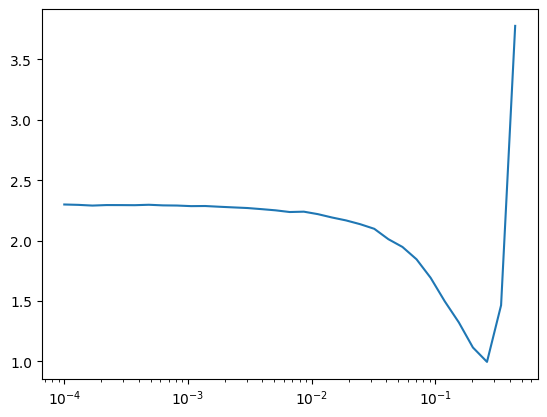

In [89]:
lrfind = LRFinderCB()
cbs = [lrfind]
model = get_model()
learner = MomentumLearner(model, dls, cbs=cbs, lr=1e-4)
learner.fit(1)
plt.plot(lrfind.lrs, lrfind.losses)
plt.xscale('log')

In [90]:
from torch.optim.lr_scheduler import ExponentialLR

In [91]:
class LRFinderCB(Callback):
  def __init__(self, gamma=1.3, max_mult=3):
    fc.store_attr()

  def before_fit(self, learn):
    self.sched = ExponentialLR(learn.opt, gamma=self.gamma)
    self.min = math.inf
    self.losses,self.lrs = [],[]

  def after_batch(self, learn):
    if not learn.training:
      raise CancelEpochException()
    loss = to_cpu(learn.loss)
    self.losses.append(loss)
    self.lrs.append(learn.opt.param_groups[0]['lr'])
    if loss < self.min:
      self.min = loss
    if math.isnan(loss) or loss>self.max_mult*self.min:
      raise CancelFitException()
    self.sched.step()

  def cleanup_fit(self, learn):
    plt.plot(self.lrs, self.losses)
    plt.xscale('log')

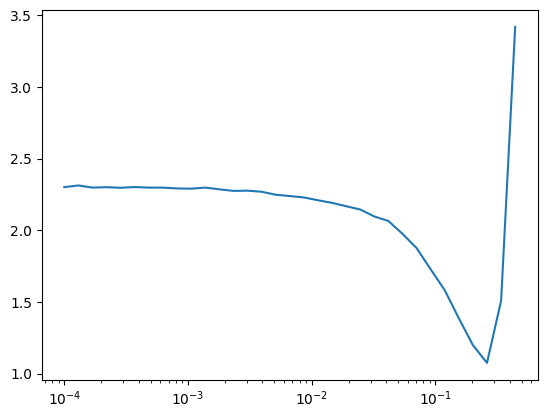

In [92]:
model = get_model()
cbs = [LRFinderCB()]
learner = MomentumLearner(model, dls, lr=1e-4, cbs=cbs)
learner.fit(1)

In [93]:
for i in range(5):
  try:
    print('first', i)
    try:
      # raise CancelEpochException()
      raise CancelFitException()
      print('inside one')
    except CancelEpochException:
      print('epoch exception')
  except CancelFitException:
    print('fit exception')
    break

first 0
fit exception
